In [0]:
!python mlip_setup_env.py

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (507/507), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 724 (delta 365), reused 344 (delta 225), pack-reused 217
Receiving objects: 100% (724/724), 6.35 MiB | 35.16 MiB/s, done.
Resolving deltas: 100% (438/438), done.
From https://github.com/L-Hess/CS4180-Deep-Learning--CNN
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.
Already on 'master'
Changing working directory to code/hw1!
joeran2 ***REMOVED***
Data not present, retrieving...
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 569kB/s]
 99% 982M/992M [00:06<00:00, 198MB/s]
100% 992M/992M [00:06<00:00, 163MB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 4.59MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 188MB/s]
100% 983M/986M [00:11<00:00, 34.1MB/s]
10

In [0]:
cd code/hw1

/content/code/hw1


In [1]:
cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/fast-compute/code/users/joeran.bosma/code/hw1


In [2]:
!git pull

Already up-to-date.


In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import categorical_accuracy
import wandb

from flow import evaluate_trained_model, generators_from_prep, preview_from_prep
from helper import generator_wrapper
from starter_eda_model_funcs import MultiOutputDataGenerator
from preprocessing import perform_preprocessing

# further settings
FIG_DIR = 'results/generated_figs/'
plt.rcParams["figure.figsize"] = (10, 4.5) # set higher on 4k monitor
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["savefig.bbox"] = 'tight'

# Ensemble predictions using models from roi-padding test
Not all models from the runs in Google Colab were saved. Available are (with the padding 5 at ROI 64 unintentional):

|    Models   |         |          |               |          |
|:-----------:|:-------:|:--------:|:--------------|:--------:|
| ROI         | Padding | CV split | Saved weights | Run id   |
| 32          | 5       |      0/8 | best          | oj3mtm8o |
| 64          | >5<     |      0/8 | best, final   | xlat0op8 |
| 96          | 15      |      0/8 | best, final   | ub5tdlzu |
| 128         | 21      |      0/8 | best, final   | so8bbr9j |
| ----------- | ------- | -------- | ------------- | -------- |
| 96          | 15      |      1/8 | best, final   | 7vpn5rmy |

<!-- \begin{table}[]
\begin{tabular}{llrll}
\cline{1-3}
\multicolumn{2}{c}{Models} &          &               &          \\ \cline{1-2}
ROI            & Padding   & CV split & Saved weights & Run id   \\ \cline{1-3}
128            & 21        & 0/8      & best, final   & so8bbr9j \\
96             & 15        & 0/8      & best, final   & ub5tdlzu \\
32             & 5         & 0/8      & best          & oj3mtm8o \\
96\_15-cv1/8   & 15        & 1/8      & best, final   & 7vpn5rmy
\end{tabular}
\end{table} -->

## Fetch and load models

In [8]:
api = wandb.Api()

roi_options = [32, 64, 96, 128]
pad_options = [ 5, 5, 15,  21]
run_ids     = ['oj3mtm8o', 'xlat0op8', 'ub5tdlzu', 'so8bbr9j']
models      = []
download = False # Download only required once

for roi_size, pad_size, run_id in zip(roi_options, pad_options, run_ids):
    model_fn = f'prep-{roi_size}-{pad_size}-model-best.h5'
    if download:
        run = api.run(f"joeranbosma/mlip/{run_id}")
        run.file("model-best.h5").download()
        os.rename('model-best.h5', model_fn)
    models.append(load_model(model_fn))

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/azureuser/.netrc


In [9]:
# set up
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

# cross validation settings
cross_val_num = 0; cross_val_parts = 8

# Ensemble prediction with data preprocessing on the fly

In [ ]:
from flow import predict_with_prep_on_the_fly
import pickle

ensemble_probs = []
train_or_test='train'

for roi_size, padding, model in zip(roi_options, pad_options, models):
    preprocess_args = dict(
        image_width=roi_size + padding*2,
        image_height=roi_size + padding*2,
        padding=padding,
    )
    
    # folders
    data_path='Data/'
    name = f"prep_{roi_size}_{padding}"
    probs = predict_with_prep_on_the_fly(model, preprocess_args, data_path=data_path,
                                         train_or_test=train_or_test)
    
    
    with open("probs_{}.pickle".format(name), "wb") as handle:
        pickle.dump(probs, handle)
    ensemble_probs.append(probs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
import pickle
ensemble_probs = []
for roi_size, padding in zip(roi_options, pad_options):
    name = f"prep_{roi_size}_{padding}"
    with open("probs_{}.pickle".format(name), "rb") as handle:
        probs = pickle.load(handle)
        ensemble_probs.append(probs)

Have predicted all of the train samples. The models were all trained on cv split 0/8, meaning that the validation samples for that split are unseen by the models. Extract those predictions and tune the model weights.  

From above have:  
`ensemble_probs` which is a list containing `probs` for each model.  
`probs` is a dictionary with:  
- `probs[f"{name}_consonant_diacritic"] = batch_predict[2][idx]`
- `probs[f"{name}_grapheme_root"] = batch_predict[0][idx]`
- `probs[f"{name}_vowel_diacritic"] = batch_predict[1][idx]`

In [14]:
from cross_validation_helper import cv_train_val_split
from helper import to_one_hot

train_or_test = 'train'
data_path = 'Data/'

# read train labels
train_df_ = pd.read_csv('{}/{}.csv'.format(data_path, train_or_test))
# add filename column to train labels df
# train_df_['filename'] = train_df_['image_id'] + '.png'

# convert target labels to one-hot encoding
# this also returns the ordered labels of the newly created columns
# one_hot_columns = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
# train_df_, features = to_one_hot(train_df_, one_hot_columns=one_hot_columns)
# assert len(features) == 168 + 11 + 7, print("found {} one-hot encoded features".format(len(features)))

# split train and validation set
train_df, val_df = cv_train_val_split(train_df_, cross_val_num=cross_val_num,
                                        cross_val_parts=cross_val_parts, random_state=576)
val_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
32759,Train_32759,72,7,0,দে
137364,Train_137364,79,7,0,ধে
156986,Train_156986,30,7,0,ঘ্নে
38345,Train_38345,69,7,0,ত্বে
83932,Train_83932,149,1,6,স্ট্র্যা


# Combine predictions and find optimal weighted ensemble

In [15]:
from sklearn.metrics import log_loss

class EnsembleClassifier(object):
    def __init__(self, names, root_preds, vowel_preds, cons_preds,
                 root_true=None,  vowel_true=None,  cons_true=None):
        # save names 
        self.names = names
        
        # predictions
        self.root_preds = root_preds
        self.vowel_preds = vowel_preds
        self.cons_preds = cons_preds
        
        # true labels (only required for calculating accuracy and loss)
        self.root_true = root_true
        self.vowel_true = vowel_true
        self.cons_true = cons_true
        
    def multiply(self, w, y):
        sh = y.shape
        # multiply y with w, along the first axis
        return (w @ y.reshape(sh[0], sh[1]*sh[2])).reshape(sh[1], sh[2])

    def weighed_pred(self, w):
        """Soft voting with weighed averaging of predicted probabilities"""
        w = np.array(w)
        
        y_root = self.multiply(w, self.root_preds) / np.sum(w)
        y_vowel = self.multiply(w, self.vowel_preds) / np.sum(w)
        y_cons = self.multiply(w, self.cons_preds) / np.sum(w)
        return y_root, y_vowel, y_cons
    
    def weighed_class(self, w):
        y_root, y_vowel, y_cons = self.weighed_pred(w)
        y_root = np.argmax(y_root, axis=-1)
        y_vowel = np.argmax(y_vowel, axis=-1)
        y_cons = np.argmax(y_cons, axis=-1)
        return y_root, y_vowel, y_cons
    
    def calc_acc(self, w):
        y_root, y_vowel, y_cons = self.weighed_class(w)
        acc_root = np.mean( y_root == self.root_true )
        acc_vowel = np.mean( y_vowel == self.vowel_true )
        acc_cons = np.mean( y_cons == self.cons_true )
        acc_glob = 0.5 * acc_root + 0.25 * (acc_vowel + acc_cons)
        return acc_root, acc_vowel, acc_cons, acc_glob
    
    def calc_loss(self, w):
        y_root, y_vowel, y_cons = self.weighed_pred(w)
        # loss = binary crossentropy, per class
        loss_root = log_loss( self.root_true, y_root )
        loss_vowel = log_loss( self.vowel_true, y_vowel )
        loss_cons = log_loss( self.cons_true, y_cons )
        # exp(-2)/exp(-1)
        loss = 0.3678794412 * loss_root + 0.25 * (loss_vowel + loss_cons)
        return loss

In [16]:
names = []
for roi_size, padding in zip(roi_options, pad_options):
    names.append( "prep_{}_{}".format(roi_size, padding) )
    
# convert ensemble_probs to three lists of probs
root_preds = np.zeros(shape=( len(ensemble_probs), val_df.index.size, 168 ))
vowel_preds = np.zeros(shape=( len(ensemble_probs), val_df.index.size, 11 ))
cons_preds = np.zeros(shape=( len(ensemble_probs), val_df.index.size, 7 ))

for i, (idx, row) in enumerate(val_df.iterrows()):
    name = row['image_id']
    
    for j in range(len(ensemble_probs)):
        root_preds[j, i] = ensemble_probs[j][name+'_grapheme_root']
        vowel_preds[j, i] = ensemble_probs[j][name+'_vowel_diacritic']
        cons_preds[j, i] = ensemble_probs[j][name+'_consonant_diacritic']

In [17]:
model = EnsembleClassifier(names, root_preds, vowel_preds, cons_preds,
                          root_true=val_df['grapheme_root'].values,
                          vowel_true=val_df['vowel_diacritic'].values,
                          cons_true=val_df['consonant_diacritic'].values,)

In [18]:
model.calc_acc(w=[1, 0, 0, 0]) # ROI 32 - pad 5 only

(0.9404102768372834, 0.9826727743477395, 0.9809599681338379, 0.961113324039036)

In [19]:
model.calc_acc(w=[1, 0, 1, 1]) # ensemble from previous run

(0.964070902210715, 0.9892850029874527, 0.9890061740689106, 0.9766082453694483)

In [20]:
model.calc_acc(w=[1, 1, 1, 1]) # all models equal weight

(0.9656243776140211,
 0.9896434973112925,
 0.9892850029874527,
 0.9775443138816968)

In [21]:
model.calc_loss(w=[1, 0, 1, 1])

0.07325927870061064

### Find optimal weight between models

In [22]:
from scipy.optimize import minimize

def ensemble_loss(w, model):
    loss = model.calc_loss(w)
    return loss

w = np.ones(shape=len(model.root_preds))
res = minimize(ensemble_loss, w, args=(model),
               options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.068343
         Iterations: 28
         Function evaluations: 192
         Gradient evaluations: 32


In [23]:
w = res.x
print(w)

[0.22600971 0.95615926 1.30780948 1.50778445]


In [24]:
model.calc_acc(w=w) # all models with optimal weight

(0.9652260505875324, 0.989523999203346, 0.9896036646086437, 0.9773949412467636)

In [25]:
def ensemble_acc_inv(w, model):
    acc_root, acc_vowel, acc_cons, acc_glob = model.calc_acc(w)
    return -acc_glob # for minimize function

res = minimize(ensemble_acc_inv, w, args=(model), method='nelder-mead', 
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.977465
         Iterations: 31
         Function evaluations: 151


### Line search to find best validation accuracy
Should at least be able to not decrease the validation accuracy of 97.754% of w=[1, 1, 1, 1].

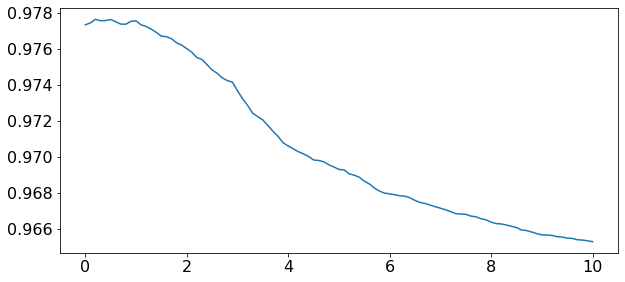

Updating w[0]: 1.0 ==> 0.2 (97.763%)


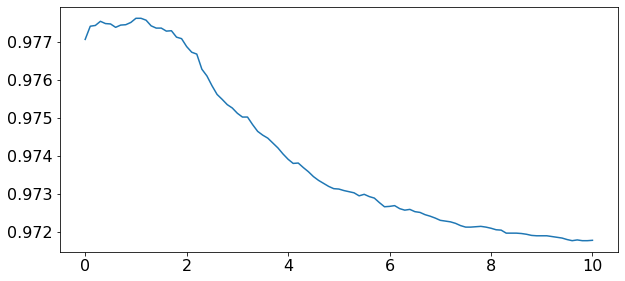

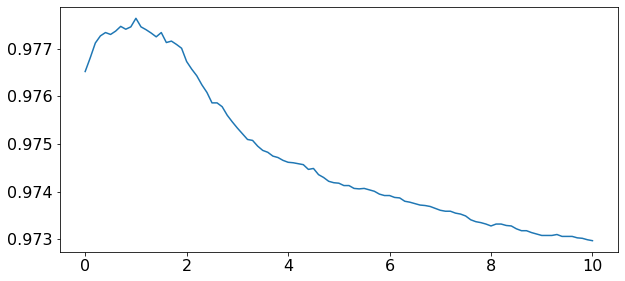

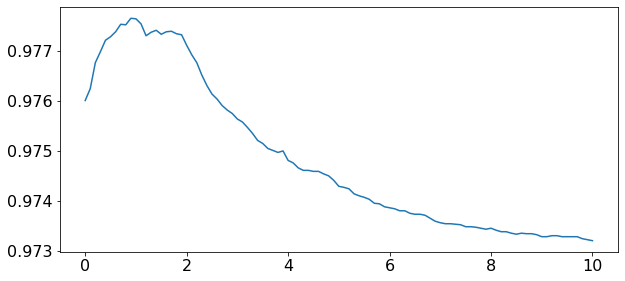

Updating w[3]: 1.0 ==> 0.9 (97.764%)


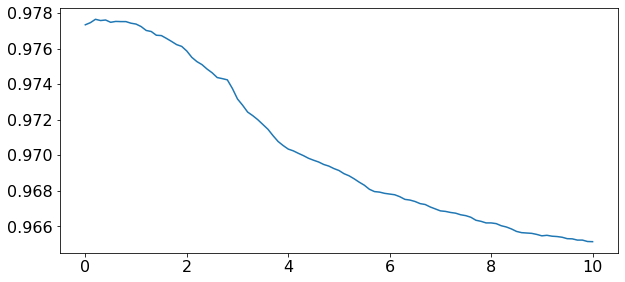

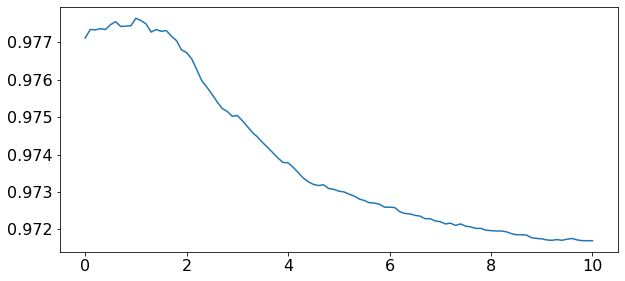

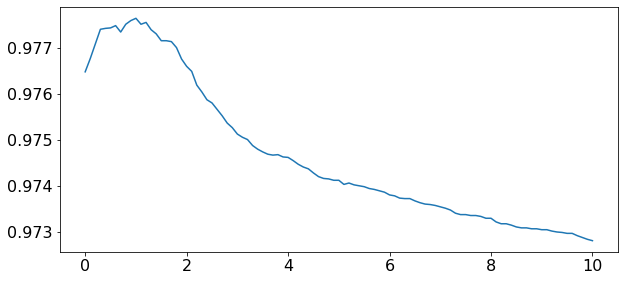

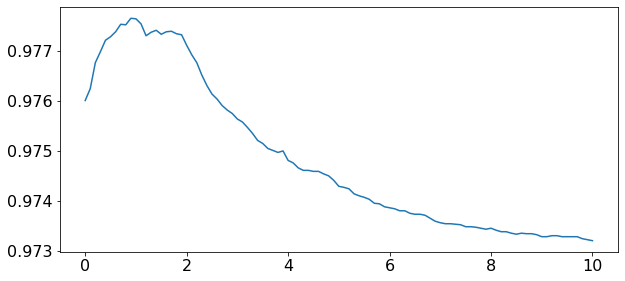

In [34]:
w = np.ones(4)

for it in range(10):
    converged = True
    
    for i in range(4):
        accs = []
        xrange = np.linspace(0, 10, num=101)
        for wi in xrange:
            wnew = w.copy()
            wnew[i] = wi

            accs.append( model.calc_acc(wnew)[3] )
        plt.plot(xrange, accs)
        plt.show()

        w_best = xrange[np.argmax(accs)]
        if w[i] != w_best:
            print("Updating w[{}]: {} ==> {} ({:,.3%})".format(i, w[i], w_best, np.max(accs)))
            w[i] = w_best
            converged = False
    
    if converged:
        break

In [35]:
print(w); print(model.calc_acc(w))

[0.2 1.  1.  0.9]
(0.9655845449113722, 0.9897231627165903, 0.9896833300139415, 0.9776438956383191)
